In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt

fontsize = 30
fontweight = 'bold'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as st

import sklearn as sk
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict
from iw import ImportanceWeightedClassifier

In [3]:
# Data locations
data_dir = 'data/UCI-hdis/'
write_dir = 'viz/'

# Hospital location
hospX = 'Budapest, Hungary'
hospX_ = 'budapest'
hospZ = 'Long Beach, CA, USA'
hospZ_ = 'longbeach'

In [4]:
# Features
feats = ['age','sex','pain','BP','chol','fbs','ecg','maxhr','eiang','eist','slope','vessels','thal','diagnosis']

# Import and read data
X = pd.read_csv(data_dir + 'processed.hungarian.data', names=feats, na_values='?')
Z = pd.read_csv(data_dir + 'processed.virginia.data', names=feats, na_values='?')

# Map classes to binary
y = ((X['diagnosis'] > 0).astype(int)).values
u = ((Z['diagnosis'] > 0).astype(int)).values

In [5]:
X0 = X['age'].values
X1 = X['chol'].values

X0[np.isnan(X0)] = 0
X1[np.isnan(X1)] = 0

XX = np.vstack((X0, X1)).T

Z0 = Z['age'].values
Z1 = Z['chol'].values

Z0[np.isnan(Z0)] = 0
Z1[np.isnan(Z1)] = 0

ZZ = np.vstack((Z0, Z1)).T

In [6]:
XXy0 = np.vstack((X0[y==0][:168], X1[y==0][:168])).T
XXy1 = np.vstack((X0[y==1][18:], X1[y==1][18:])).T
XX = np.vstack((XXy0, XXy1))
yy = np.vstack((np.zeros((168,1), dtype='uint8'), np.ones((88,1), dtype='uint8')))[:,0]

In [7]:
# Generate grid
tx, ty = np.mgrid[20:80:.1, 50:650:1]
grid = np.c_[tx.ravel(), ty.ravel()]

# Range limits for features
age_lim = [20, 80]
chol_lim = [50, 650]

In [8]:
def iwe_ratio_gaussians(X, Z, l2=0.0):
    """
    Estimate importance weights based on a ratio of Gaussian distributions.

    INPUT   (1) array 'X': source data (N samples by D features)
            (2) array 'Z': target data (M samples by D features)
    OUTPUT  (1) array: importance weights (N samples by 1)
    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Assert equivalent dimensionalities
    assert DX == DZ

    # Sample means in each domain
    mu_X = np.mean(X, axis=0)
    mu_Z = np.mean(Z, axis=0)

    # Sample covariances
    Si_X = np.cov(X.T) + l2*np.eye(2)
    Si_Z = np.cov(Z.T) + l2*np.eye(2)

    # Compute probability of X under each domain
    pT = st.multivariate_normal.pdf(X, mu_Z, Si_Z)
    pS = st.multivariate_normal.pdf(X, mu_X, Si_X)

    # Check for numerics
    assert not np.any(np.isnan(pT)) or np.any(pT == 0)
    assert not np.any(np.isnan(pS)) or np.any(pS == 0)

    # Return the ratio of probabilities
    return pT / pS

def iwe_kernel_densities(X, Z):
    """
    Estimate importance weights based on kernel density estimation.

    INPUT   (1) array 'X': source data (N samples by D features)
            (2) array 'Z': target data (M samples by D features)
    OUTPUT  (1) array: importance weights (N samples by 1)
    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Assert equivalent dimensionalities
    assert DX == DZ

    # Compute probabilities based on source kernel densities
    pT = st.gaussian_kde(Z.T).pdf(X.T)
    pS = st.gaussian_kde(X.T).pdf(X.T)

    # Check for numerics
    assert not np.any(np.isnan(pT)) or np.any(pT == 0)
    assert not np.any(np.isnan(pS)) or np.any(pS == 0)

    # Return the ratio of probabilities
    return pT / pS

def iwe_logistic_discrimination(X, Z, l2=1.0):
    """
    Estimate importance weights based on logistic regression.

    INPUT   (1) array 'X': source data (N samples by D features)
            (2) array 'Z': target data (M samples by D features)
    OUTPUT  (1) array: importance weights (N samples by 1)
    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Assert equivalent dimensionalities
    assert DX == DZ

    # Make domain-label variable
    y = np.concatenate((np.zeros((N, 1)),
                        np.ones((M, 1))), axis=0)

    # Concatenate data
    XZ = np.concatenate((X, Z), axis=0)

    # Call a logistic regressor
    lr = LogisticRegression(C=l2, solver='lbfgs').fit(XZ, y[:,0])

    # Predict probability of belonging to target using cross-validation
    preds = lr.predict_proba(XZ)

    # Return predictions for source samples
    return preds[:N,1]

In [9]:
W = iwe_logistic_discrimination(XX, ZZ, l2=10.)

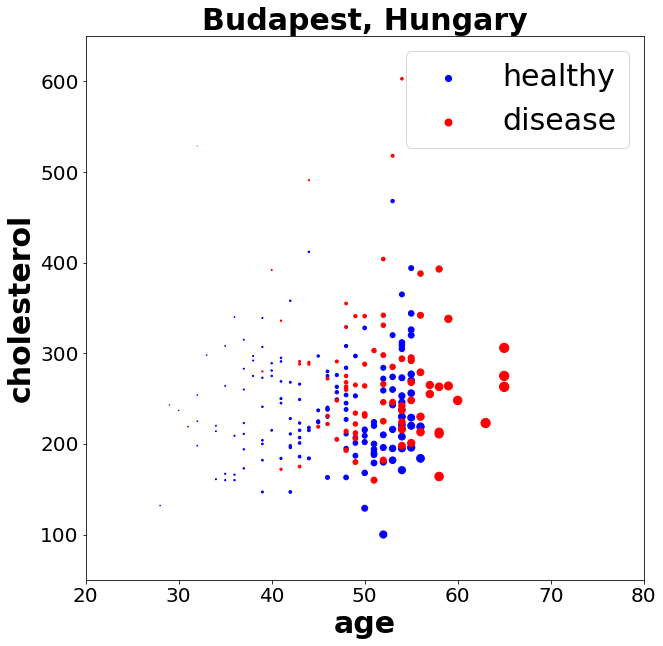

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(XX[yy==0,0], XX[yy==0,1], s=W[yy==0]*100, c='b', label='healthy')
ax.scatter(XX[yy==1,0], XX[yy==1,1], s=W[yy==1]*100, c='r', label='disease')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_iw.png', bbox_inches='tight', padding='none')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


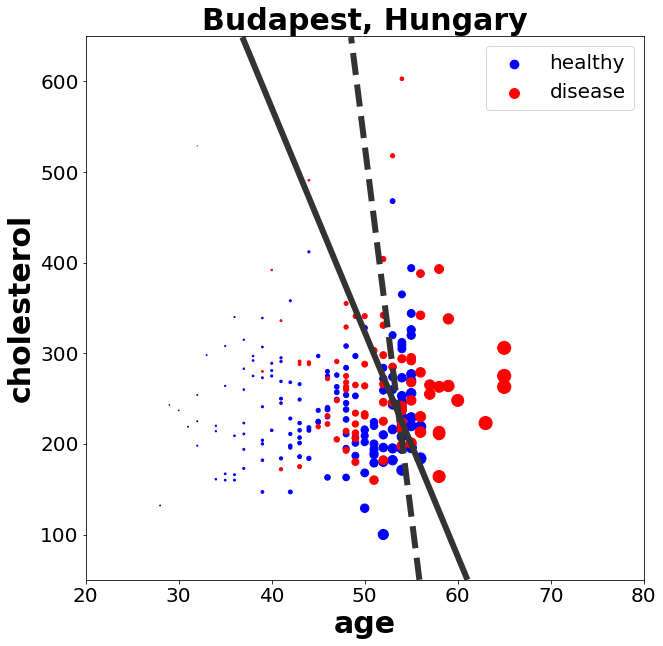

In [11]:
# Train classifier
clfN = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(XX, yy)
probsN = clfN.predict_proba(grid)[:, 1].reshape(tx.shape)

# Train classifier
clf = LogisticRegression(C=10., solver='lbfgs').fit(XX, yy, sample_weight=W)

# Make predictions
probs = clf.predict_proba(grid)[:, 1].reshape(tx.shape)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(XX[yy==0,0], XX[yy==0,1], s=W[yy==0]*200, c='b', label='healthy')
ax.scatter(XX[yy==1,0], XX[yy==1,1], s=W[yy==1]*200, c='r', label='disease')

ax.legend(fontsize=fontsize-10)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospX + '_age-chol_n256_iw_dboundary.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospX + '_age-chol_n256_iw_dboundary.eps', bbox_inches='tight', padding='none')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


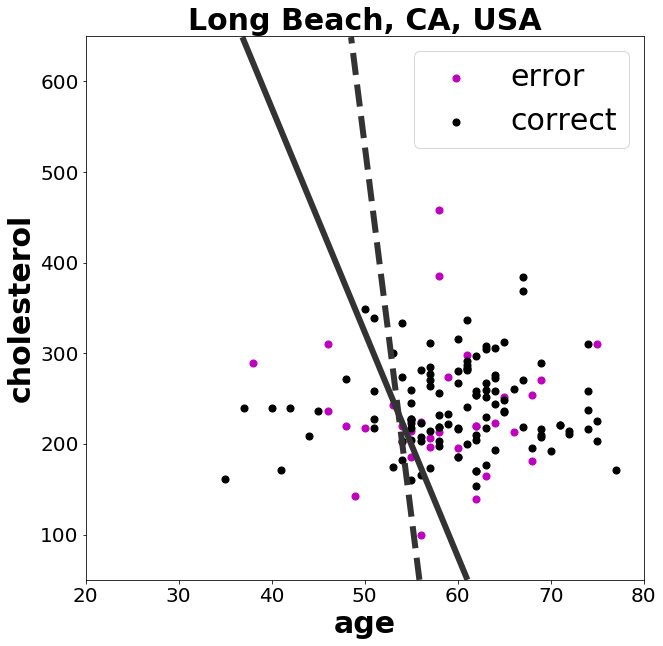

In [12]:
predsN = (clfN.predict(ZZ)).astype('uint8') 
correct = (predsN == u).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[correct==0], Z1[correct==0], s=50, c='m', label='error')
ax.scatter(Z0[correct==1], Z1[correct==1], s=50, c='k', label='correct')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ + '_age-chol_nN_iw_preds_bw.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ + '_age-chol_nN_iw_errors_bw.eps', bbox_inches='tight', padding='none')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


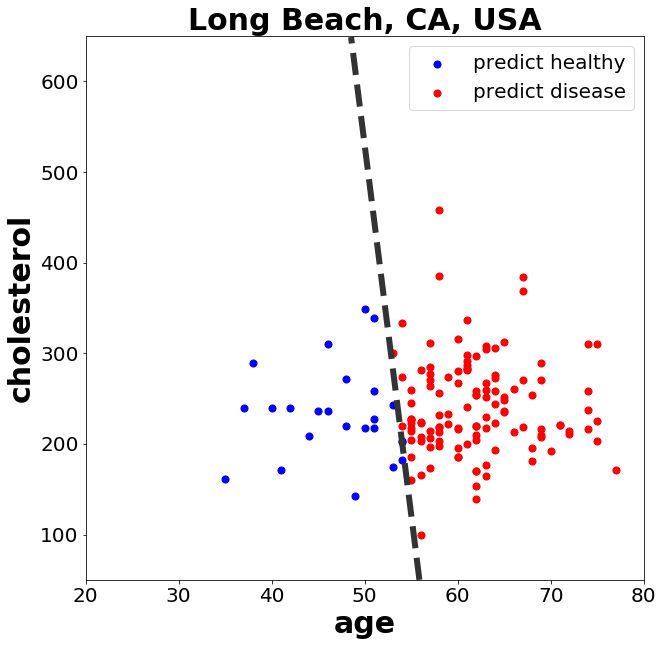

In [13]:
preds = (clf.predict(ZZ)).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[preds==0], Z1[preds==0], s=50, c='b', label='predict healthy')
ax.scatter(Z0[preds==1], Z1[preds==1], s=50, c='r', label='predict disease')

ax.legend(fontsize=fontsize-10)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ + '_age-chol_nN_iw_preds.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ + '_age-chol_nN_iw_preds.eps', bbox_inches='tight', padding='none')


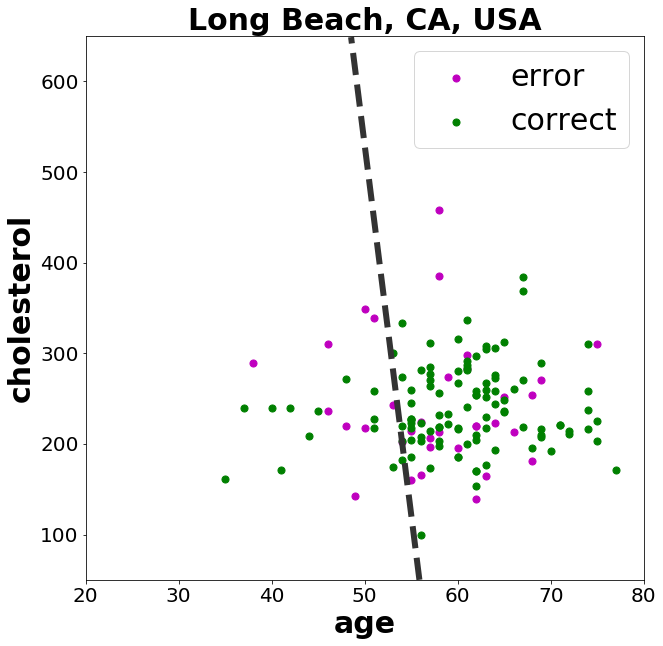

In [14]:
preds = (clf.predict(ZZ)).astype('uint8')
correct = (preds == u).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[correct==0], Z1[correct==0], s=50, c='m', label='error')
ax.scatter(Z0[correct==1], Z1[correct==1], s=50, c='g', label='correct')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ + '_age-chol_nN_iw_correct.png', bbox_inches='tight', padding='none')


In [15]:
W = iwe_ratio_gaussians(XX, ZZ, l2=100.)

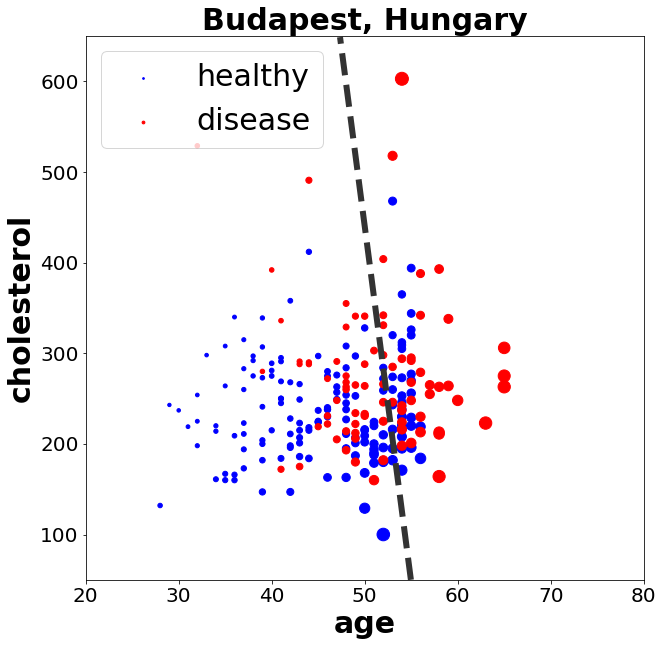

In [16]:
# Train classifier
clf = LogisticRegression(C=10., solver='lbfgs').fit(XX, yy, sample_weight=W)

# Make predictions
probs = clf.predict_proba(grid)[:, 1].reshape(tx.shape)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(XX[yy==0,0], XX[yy==0,1], s=W[yy==0]*100, c='b', label='healthy')
ax.scatter(XX[yy==1,0], XX[yy==1,1], s=W[yy==1]*100, c='r', label='disease')

ax.legend(fontsize=fontsize, loc=2, markerscale=0.1)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

# Plot decision boundary
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospX + '_age-chol_n256_iw_dboundary03.png', bbox_inches='tight', padding='none')
